# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains $60'000+10'000$ handwritten digits to be classified as a number between $0$ and $9$.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification
3. Defining and evaluating the baseline model
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


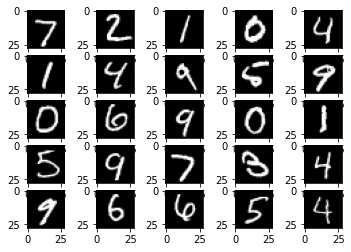

In [ ]:
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [ ]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy

Reshape data to have a single b/w channel. (if color, we would have 3 channels, maybe 4 with alpha channel)

In [ ]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [ ]:
n_classes = len(unique(y_train))
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

Simple linear normalization, pixels are from 0 to 255, to divide by 255 to put them all between 0 and 1

Note that the distribution of the pixel values is not important here. Because this we do not need to worry about normalizing with std dev, etc. We can just do a simple normalization

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary `depth`, `kernel_width`, and `pool_stride` of the models.

In [ ]:
def make_model(depth, kernel_width, pool_stride, add_dense = False):
    # A sequential model, adds layers
    model = Sequential()
    
    # Convolutional layer, 2D Conv because we have 2D image
    # 2d conv kernels width and depth, quadratic (width in both directions)
    # relu
    # input shape taken from above
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu', input_shape=in_shape))
    
    # maximum of certain area (given by the stride)
    model.add(MaxPool2D((pool_stride, pool_stride)))
    
    # We get a tensor from previous, now we flatten it
    model.add(Flatten())

    if add_dense:
        # Arbitrarily add additional layer
        model.add(Dense(100, activation='relu'))

        # Add dropout, varies the network by making some 
        # of the neurons blind over the minibatch
        model.add(Dropout(0.5))
    
    # Add an output layer
    # because we want a "decider", we choose softmax as opposed
    # to rely. Softmax is a soft step function
    # helps in classification
    model.add(Dense(n_classes, activation='softmax'))
    
    # Combine layers
    # use ADAM for optimization
    # use cross entropy for loss, compare diff distributions
    # use accuracy as metric
    # measure using loss, goal using metric
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

Define learning parameters for all models.

In [ ]:
# try diff epochs and see results
EPOCHS = 10
BATCH_SIZE = 128

early_stopping = EarlyStopping(
    monitor='val_accuracy', # accuracy on the test set
    verbose=1,
    patience=10, # if no imrpovement after these epochs, stop early
    mode='max', # maximzation of accuracy?
    restore_best_weights=True) # load best weights when done

Function to show the history of training.

In [ ]:
def plot_metrics(history,title=""):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'accuracy']
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.title(title)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],
             color=colors[0], linestyle="--", label='Val')
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1])
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

# Note to Sebastian/Welf

I did hyperparameter tuning. If you need to run this notebook, it will take some time. I used Google Colab with GPU enabled, so running all of my models there should only take 5 minutes or so.

## Derek Model 1

### Before Comments
In this model I am establishing a baseline. I am starting by doing a hyperparameter search on the convolution2d layer and testing the number of filters from 8 up to 64. 

I will keep the kernel to a size of 3x3. My reasoning is that the image is only 28x28 pixels and that a larger kernel would lose too much information. I will also not change the stride for the same reason, and I will not touch the padding either.

I expect that this overall model will perform well but not as high as Welf's final model which included the second dense layer (This model does not include a second dense layer). I am referring to accuracy. Also, the number of parameters will be relatively low because the model has a pooling layer and only one dense output layer.

I am curious about the number of filters in the convolution layers and how that number affects the performance. I am also curious if one could use their intuition to figure out a suitable number or if it just comes from experimentation and experience. For example, could I intuitively think about the different features of a handwritten digit and use that intuition to set the correct hyperparameter.

### After Comments

Regarding the number of filters, I see that with 32 filters, we achieved the highest accuracy. The validation loss and the training loss are increasingly divergent as we increase the number of filters. 

### Testing

In [ ]:
model_d1_list = []
for index, i in enumerate(range(2,9)):
  numfilters= 8*i
  model_d1 = Sequential()
  model_d1.add(Conv2D(numfilters, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
  model_d1.add(MaxPool2D((2, 2)))
  model_d1.add(Flatten())
  # model_d1.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  # model_d1.add(Dropout(0.5))
  model_d1.add(Dense(n_classes, activation='softmax'))
  model_d1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # model_d1.summary()
  model_d1_list.append({"filters":str(numfilters),"model":model_d1})



In [ ]:
for m in model_d1_list:
  numfilters = m["filters"]
  model = m["model"]
  history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)
  m["history"] = history




### Plots

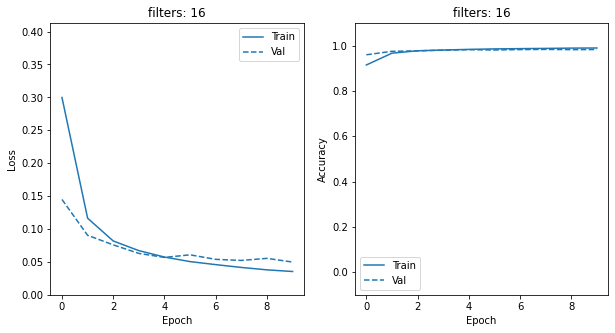

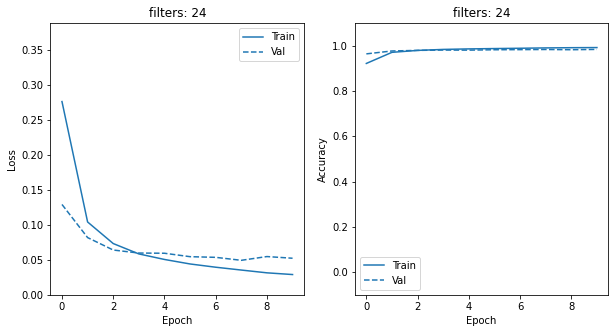

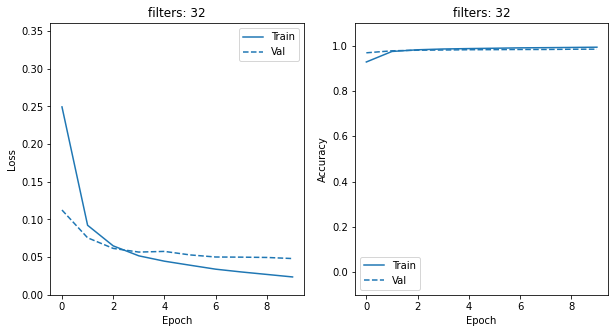

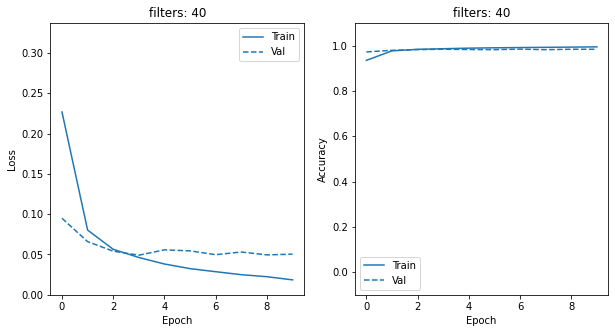

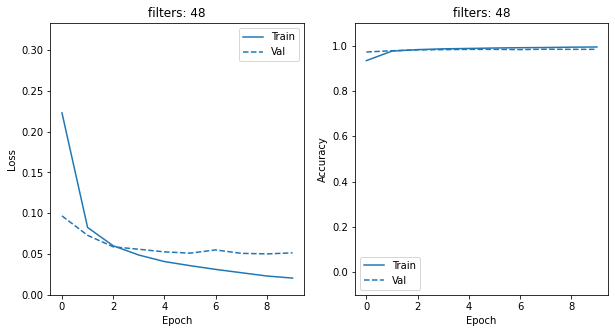

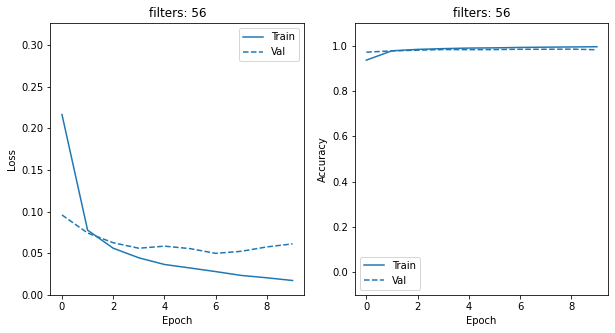

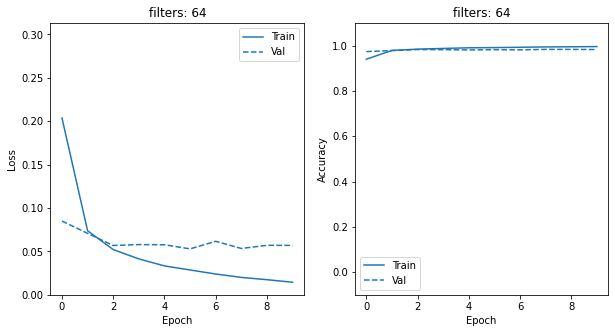

In [ ]:
for m in model_d1_list:
  plot_metrics(m["history"],("filters: " + m["filters"]))

### Summary

In [ ]:
best_m1 = None
for m in model_d1_list:
  
  model = m["model"]
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  m["acc"] = acc
  print("Filters: "+m["filters"] +', Accuracy: %.4f' % acc)
  if best_m1 is None or acc > best_m1["acc"]:
    best_m1 = m 

print("\nBest num filters:",best_m1["filters"],"with test accuracy:",best_m1["acc"])
best_m1["model"].summary()

Filters: 16, Accuracy: 0.9829
Filters: 24, Accuracy: 0.9834
Filters: 32, Accuracy: 0.9845
Filters: 40, Accuracy: 0.9840
Filters: 48, Accuracy: 0.9838
Filters: 56, Accuracy: 0.9819
Filters: 64, Accuracy: 0.9829

Best num filters: 32 with test accuracy: 0.984499990940094
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
___________________________________________

## Derek Model 2


### Before Comments
For models 2, 3, 4 I will put the comments here. I consider them part of the same experiment. 

I am testing the addition of a 2nd convolution layer as well as testing the number and placement of maxpool layers. Model 2 has a maxpool layer after each conv layer, Model 3 has only one maxpool layer after the first conv layer, and model 4 has only one maxpool layer after the 2nd conv layer.

The maxpool layers have the same configuration in each of these tests, however for the two conv layers I do a hyper parameter grid search over the number of filters. This time I am testing only 16, 32, and 64 filters.

My assumption before getting started is that the accuracy of one of the models which contain only one maxpool layer will perform best. The concept of maxpool seems to be a way to balance the reduction of parameters with the performance. However, I also see that the idea of "local interactions" is important to conv networks. Pooling seems to be a way, in addition to the kernel, to incorporate local interactions into the model.

For the number of parameters, the model with 2 pooling layers should have the least amount of parameters of these three models.

### After Comments
My assumption was wrong! The model with 2 pooling layers performed best, using test accuracy as the benchmark. It also had the least amount of parameters. Pooling is obviously an essential part of conv networks and also shows that smaller networks does not mean worse accuracy. 

Another interesting finding is that the two conv layers had different numbers of filters. From the gridsearch, the model with 32 filters in the first cov layer and 64 in the second layer performed best with a test accuracy of 0.9896.

Again, with increasing number of filters, the divergence between the train loss and validation loss inceases. The validation loss diverges from train loss around 3 epochs.


### Testing

In [ ]:
numfilterslist = [16,32,64]
model_d2_list = []
for filtconv1 in numfilterslist:
  for filtconv2 in numfilterslist:
    model_d2 = Sequential()
    model_d2.add(Conv2D(filtconv1, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
    model_d2.add(MaxPool2D((2, 2)))
    model_d2.add(Conv2D(filtconv2, (3,3), activation='relu', kernel_initializer='he_uniform'))
    model_d2.add(MaxPool2D((2, 2)))
    model_d2.add(Flatten())
    # model_d2.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model_d2.add(Dropout(0.5))
    model_d2.add(Dense(n_classes, activation='softmax'))
    model_d2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model_d2.summary()
    model_d2_list.append({"filters_1":str(filtconv1),"filters_2":str(filtconv2),"model":model_d2})



In [ ]:
for m in model_d2_list:
  model = m["model"]
  history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)
  m["history"] = history




### Plots

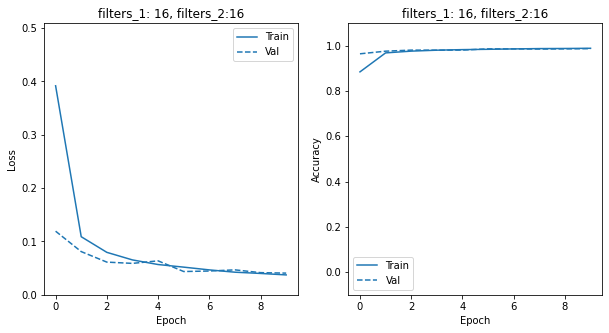

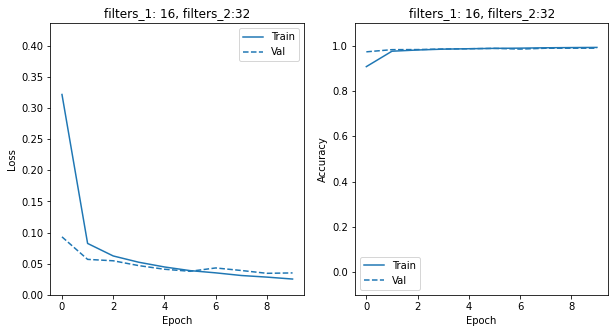

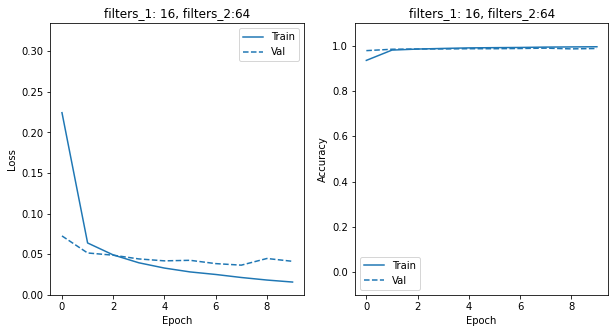

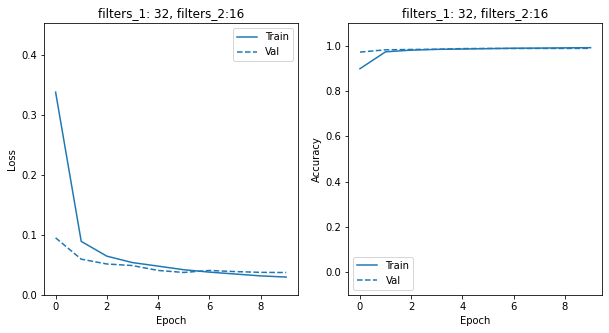

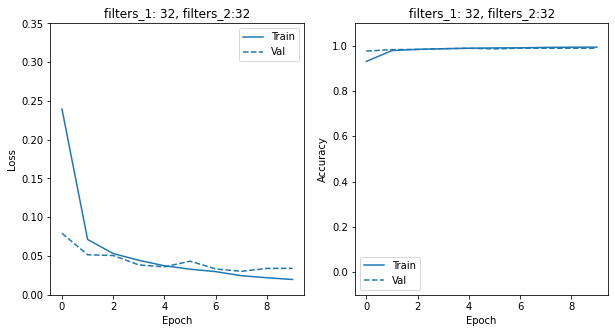

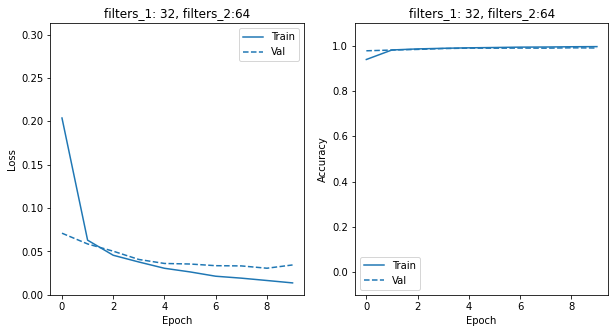

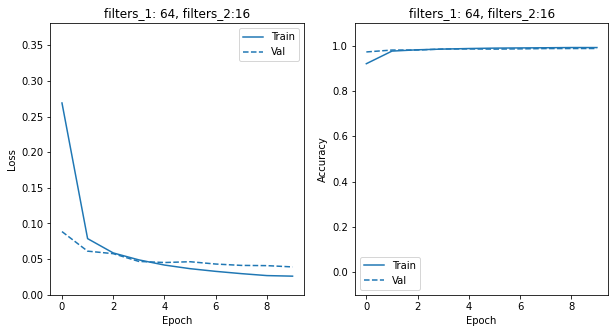

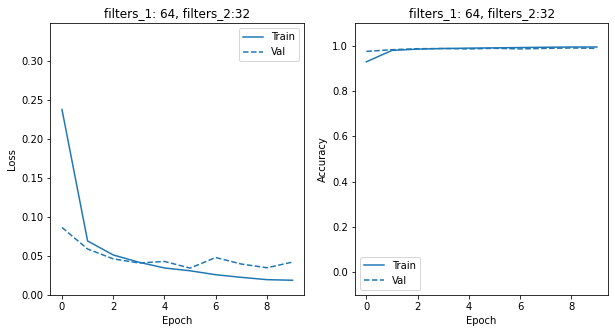

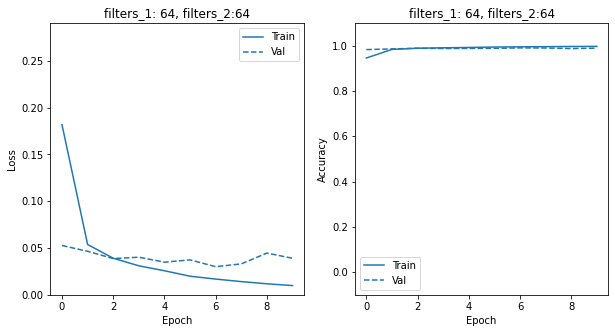

In [ ]:
for m in model_d2_list:
  plot_metrics(m["history"],("filters_1: " + m["filters_1"] + ", filters_2:"+m["filters_2"]))

### Summary

In [ ]:
best_m2 = None
for m in model_d2_list:
  
  model = m["model"]
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  m["acc"] = acc
  print("Filters_1: "+m["filters_1"] + ", filters_2: " +m["filters_2"] + ', Accuracy: %.4f' % acc)
  if best_m2 is None or acc > best_m2["acc"]:
    best_m2 = m 

print("\nBest num filters_1:",best_m2["filters_1"],"best num filters_2:"+best_m2["filters_2"],"with test accuracy:",best_m2["acc"])
best_m2["model"].summary()

Filters_1: 16, filters_2: 16, Accuracy: 0.9868
Filters_1: 16, filters_2: 32, Accuracy: 0.9888
Filters_1: 16, filters_2: 64, Accuracy: 0.9874
Filters_1: 32, filters_2: 16, Accuracy: 0.9880
Filters_1: 32, filters_2: 32, Accuracy: 0.9887
Filters_1: 32, filters_2: 64, Accuracy: 0.9896
Filters_1: 64, filters_2: 16, Accuracy: 0.9874
Filters_1: 64, filters_2: 32, Accuracy: 0.9881
Filters_1: 64, filters_2: 64, Accuracy: 0.9889

Best num filters_1: 32 best num filters_2:64 with test accuracy: 0.9896000027656555
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 11, 11, 64)        18496     
_______

## Derek Model 3

Only one maxpool after two conv2d layers

### Testing

In [ ]:
numfilterslist = [16,32,64]
model_d3_list = []
for filtconv1 in numfilterslist:
  for filtconv2 in numfilterslist:
    model_d3 = Sequential()
    model_d3.add(Conv2D(filtconv1, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
    model_d3.add(Conv2D(filtconv2, (3,3), activation='relu', kernel_initializer='he_uniform'))
    model_d3.add(MaxPool2D((2, 2)))
    model_d3.add(Flatten())
    # model_d3.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model_d3.add(Dropout(0.5))
    model_d3.add(Dense(n_classes, activation='softmax'))
    model_d3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model_d3.summary()
    model_d3_list.append({"filters_1":str(filtconv1),"filters_2":str(filtconv2),"model":model_d3})



In [ ]:
for m in model_d3_list:
  model = m["model"]
  history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)
  m["history"] = history




### Plots

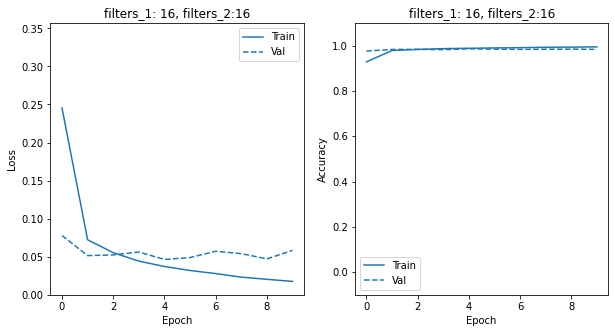

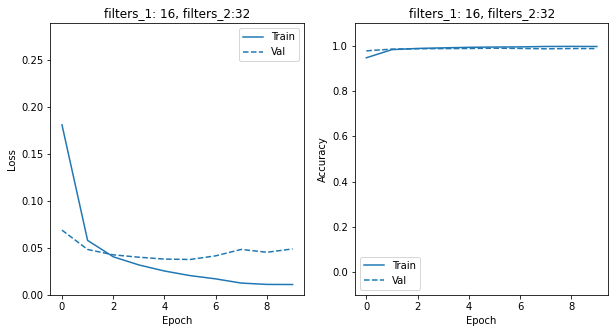

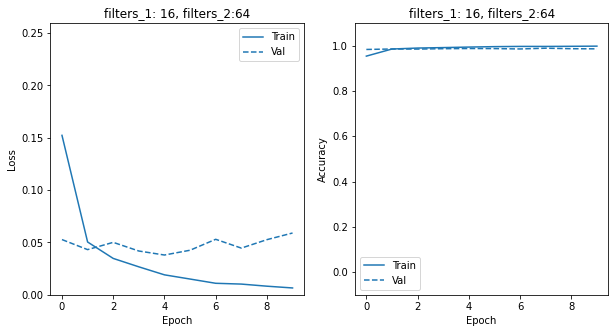

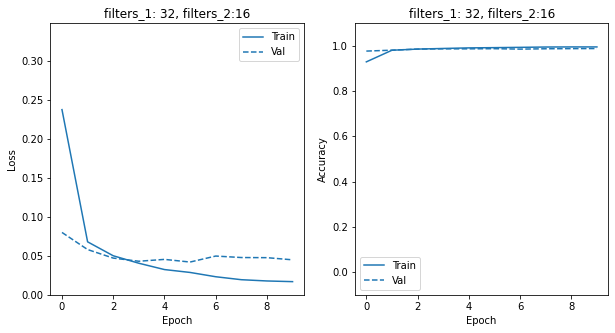

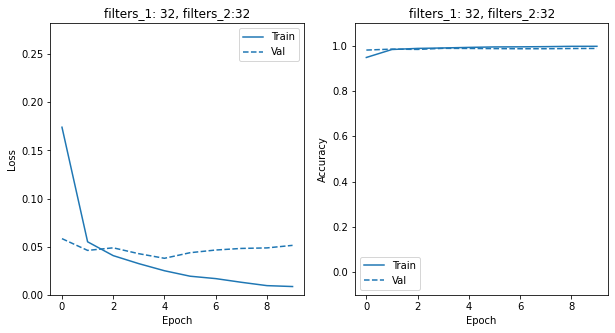

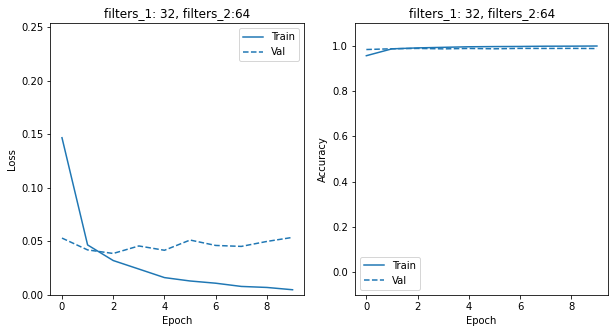

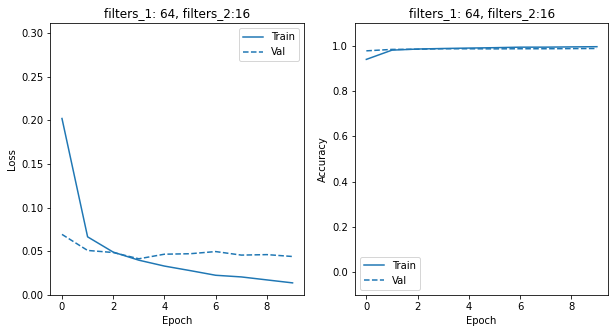

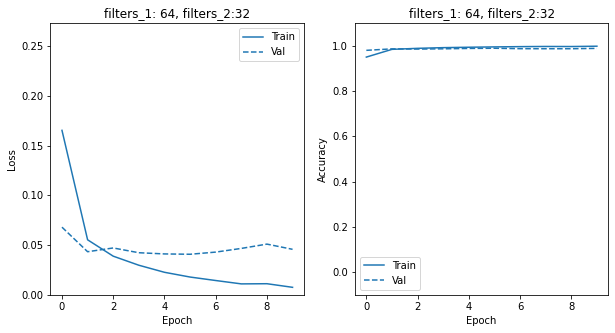

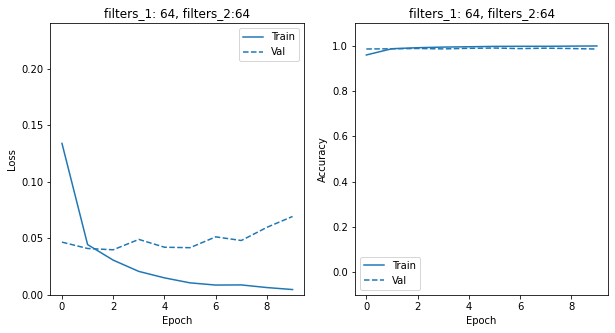

In [ ]:
for m in model_d3_list:
  plot_metrics(m["history"],("filters_1: " + m["filters_1"] + ", filters_2:"+m["filters_2"]))

### Summary

In [ ]:
best_m3 = None
for m in model_d3_list:
  
  model = m["model"]
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  m["acc"] = acc
  print("Filters_1: "+m["filters_1"] + ", filters_2: " +m["filters_2"] + ', Accuracy: %.4f' % acc)
  if best_m3 is None or acc > best_m3["acc"]:
    best_m3 = m 

print("Best num filters_1:",best_m3["filters_1"],"best num filters_2:"+best_m3["filters_2"],"with test accuracy:",best_m3["acc"])
best_m3["model"].summary()

Filters_1: 16, filters_2: 16, Accuracy: 0.9835
Filters_1: 16, filters_2: 32, Accuracy: 0.9870
Filters_1: 16, filters_2: 64, Accuracy: 0.9859
Filters_1: 32, filters_2: 16, Accuracy: 0.9872
Filters_1: 32, filters_2: 32, Accuracy: 0.9876
Filters_1: 32, filters_2: 64, Accuracy: 0.9872
Filters_1: 64, filters_2: 16, Accuracy: 0.9874
Filters_1: 64, filters_2: 32, Accuracy: 0.9879
Filters_1: 64, filters_2: 64, Accuracy: 0.9851
Best num filters_1: 64 best num filters_2:32 with test accuracy: 0.9879000186920166
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 12, 12, 32)        0         
________

## Derek Model 4

Only one maxpool after the first conv2d layer. No maxpool after the 2nd conv2d layer.

### Testing

In [ ]:
numfilterslist = [16,32,64]
model_d4_list = []
for filtconv1 in numfilterslist:
  for filtconv2 in numfilterslist:
    model_d4 = Sequential()
    model_d4.add(Conv2D(filtconv1, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
    model_d4.add(MaxPool2D((2, 2)))
    model_d4.add(Conv2D(filtconv2, (3,3), activation='relu', kernel_initializer='he_uniform'))
    model_d4.add(Flatten())
    # model_d4.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model_d4.add(Dropout(0.5))
    model_d4.add(Dense(n_classes, activation='softmax'))
    model_d4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # model_d4.summary()
    model_d4_list.append({"filters_1":str(filtconv1),"filters_2":str(filtconv2),"model":model_d4})



In [ ]:
for m in model_d4_list:
  model = m["model"]
  history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)
  m["history"] = history




### Plots

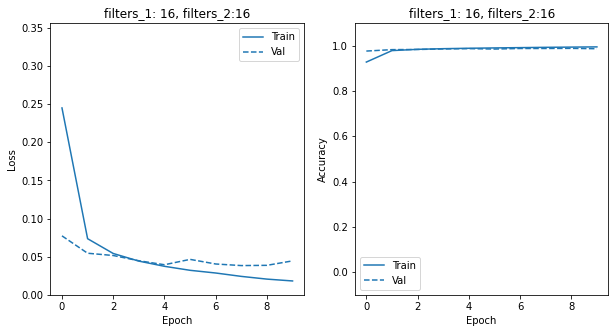

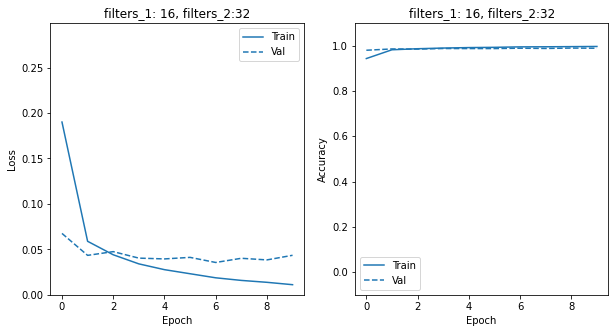

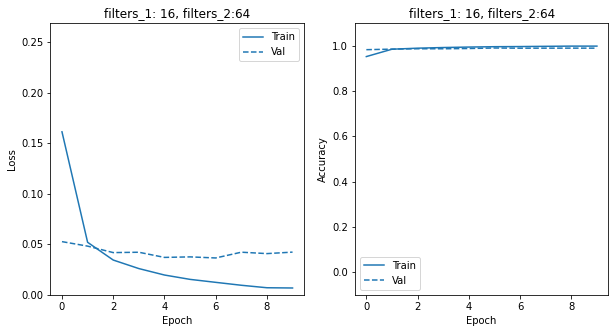

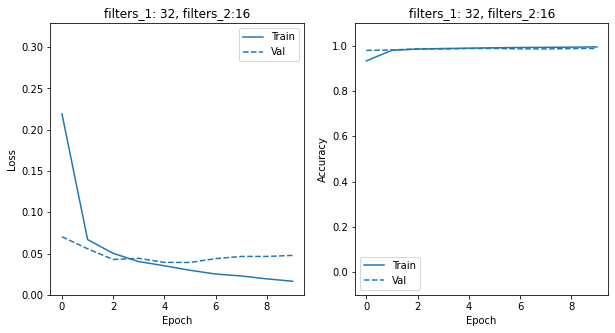

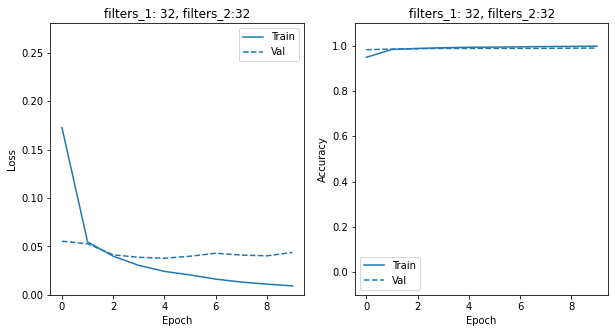

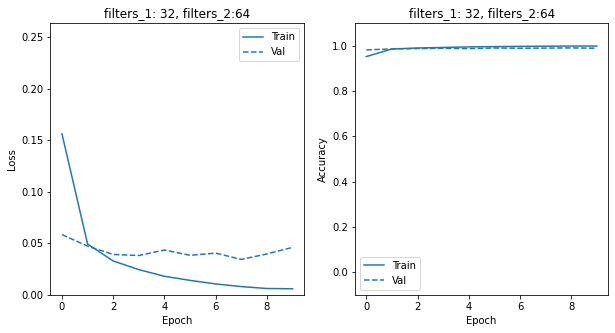

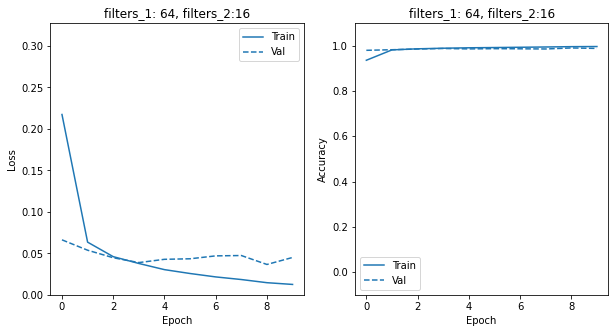

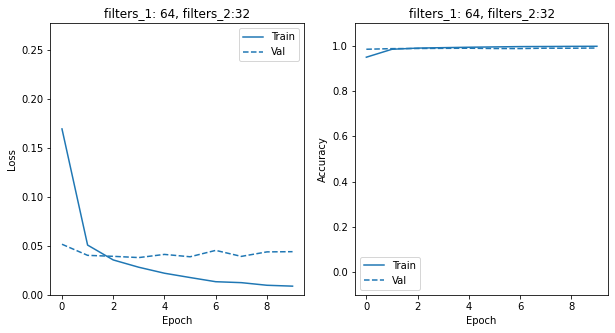

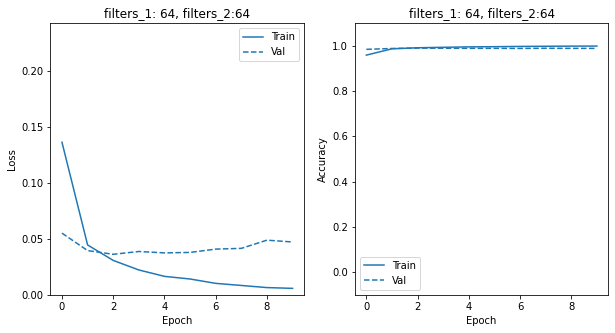

In [ ]:
for m in model_d4_list:
  plot_metrics(m["history"],("filters_1: " + m["filters_1"] + ", filters_2:"+m["filters_2"]))

### Summary

In [ ]:
best_m4 = None
for m in model_d4_list:
  
  model = m["model"]
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  m["acc"] = acc
  print("Filters_1: "+m["filters_1"] + ", filters_2: " +m["filters_2"] + ', Accuracy: %.4f' % acc)
  if best_m4 is None or acc > best_m4["acc"]:
    best_m4 = m 

print("Best num filters_1:",best_m4["filters_1"],"best num filters_2:"+best_m4["filters_2"],"with test accuracy:",best_m4["acc"])
best_m4["model"].summary()

Filters_1: 16, filters_2: 16, Accuracy: 0.9864
Filters_1: 16, filters_2: 32, Accuracy: 0.9886
Filters_1: 16, filters_2: 64, Accuracy: 0.9889
Filters_1: 32, filters_2: 16, Accuracy: 0.9879
Filters_1: 32, filters_2: 32, Accuracy: 0.9892
Filters_1: 32, filters_2: 64, Accuracy: 0.9886
Filters_1: 64, filters_2: 16, Accuracy: 0.9878
Filters_1: 64, filters_2: 32, Accuracy: 0.9895
Filters_1: 64, filters_2: 64, Accuracy: 0.9879
Best num filters_1: 64 best num filters_2:32 with test accuracy: 0.9894999861717224
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 11, 11, 32)        18464     
________

## Derek Model 5

### Before comments

Finally I am adding the 2nd dense layer. I am using the best model from the previous experiments: 2 conv layers with 2 maxpool layers.

I will experiment here with the value of dropout and the number of units in the first dense layer.

I expect that the accuracy will increase and that the number of parameters will increase. However, since I have two maxpool layers, I expect the total number of parameters to still be less than Welf's final model.

### After comments

This model performed best with regards to accuracy, achieving .9925 on test accuracy. The number of paramaters was 140,682, with 64 units and a dropout rate of 0.4.

The additional dense layer is important for boosting the performance. In additional testing I would have added even more dense layers to see the effect there.

This goes to show that the techniques used to reduce complexity and prevent overfitting really do work in practice to produce performant model in production.

The results of all of the models are tabulated below.

### Testing

In [ ]:
dense1list = [32,64,96]
dropoutlist = [.2, .3, .4]
numfilters = 64
model_d5_list = []
for dense1 in dense1list:
  for dropout in dropoutlist:
    model_d5 = Sequential()
    model_d5.add(Conv2D(numfilters, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
    model_d5.add(MaxPool2D((2, 2)))
    model_d5.add(Conv2D(numfilters, (3,3), activation='relu', kernel_initializer='he_uniform'))
    model_d5.add(MaxPool2D((2, 2)))
    model_d5.add(Flatten())
    model_d5.add(Dense(dense1, activation='relu', kernel_initializer='he_uniform'))
    model_d5.add(Dropout(dropout))
    model_d5.add(Dense(n_classes, activation='softmax'))
    model_d5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_d5_list.append({"dense_1":str(dense1),"dropout":str(dropout),"model":model_d5})



In [ ]:
for m in model_d5_list:
  model = m["model"]
  history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    verbose=0,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)
  m["history"] = history

### Plots

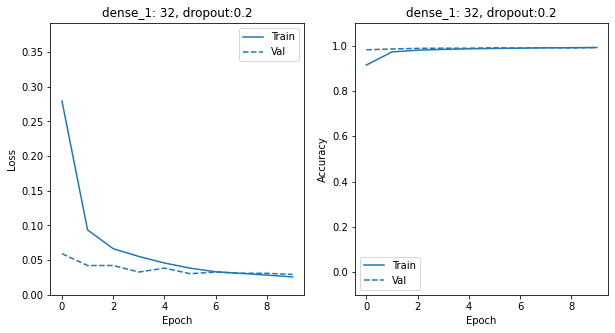

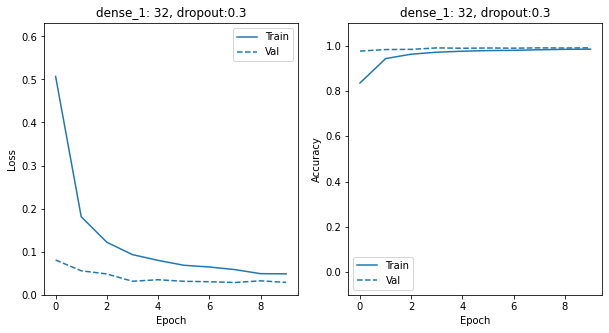

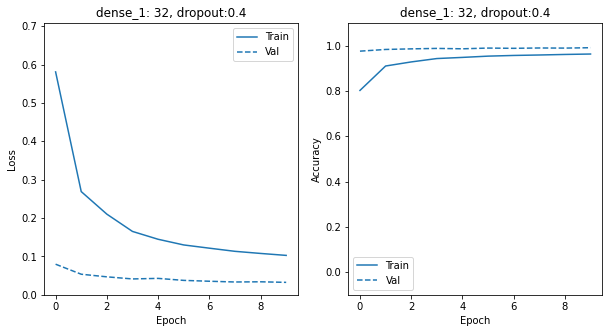

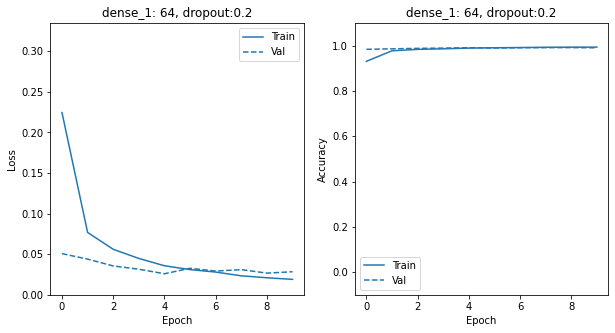

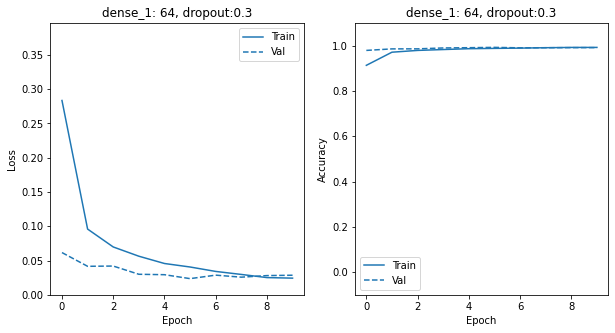

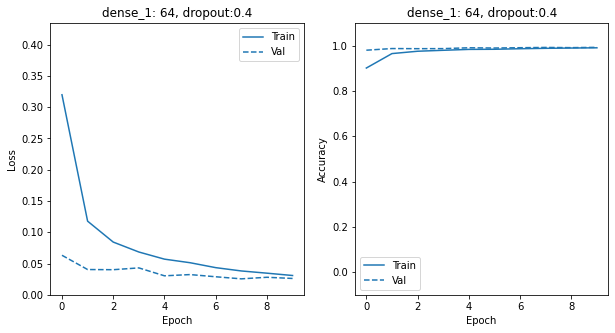

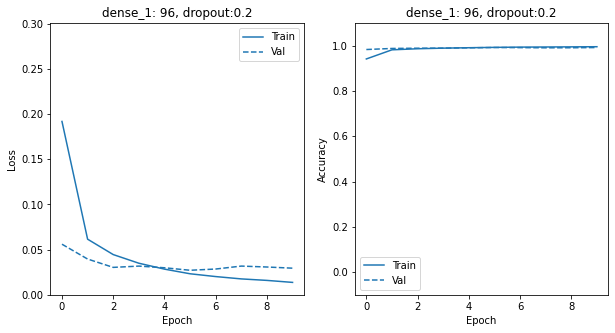

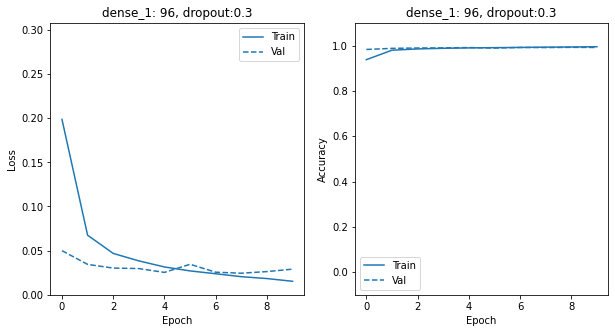

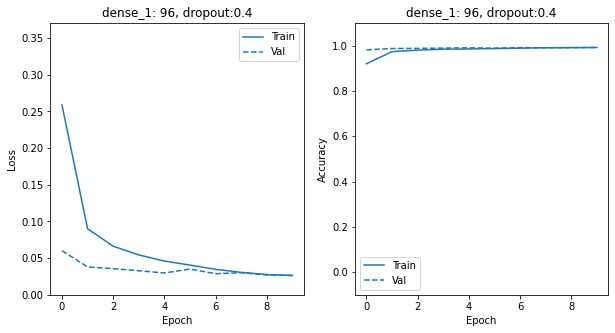

In [ ]:
for m in model_d5_list:
  plot_metrics(m["history"],("dense_1: " + m["dense_1"] + ", dropout:"+m["dropout"]))

### Summary

In [ ]:
best_m5 = None
for m in model_d5_list:
  
  model = m["model"]
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  m["acc"] = acc
  print("Dense units: "+m["dense_1"] + ", dropout: " +m["dropout"] + ', Accuracy: %.4f' % acc)
  if best_m5 is None or acc > best_m5["acc"]:
    best_m5 = m 

print("Best units:",best_m5["dense_1"],"best dropout:"+best_m5["dropout"],"with test accuracy:",best_m5["acc"])
best_m5["model"].summary()

Dense units: 32, dropout: 0.2, Accuracy: 0.9919
Dense units: 32, dropout: 0.3, Accuracy: 0.9905
Dense units: 32, dropout: 0.4, Accuracy: 0.9909
Dense units: 64, dropout: 0.2, Accuracy: 0.9905
Dense units: 64, dropout: 0.3, Accuracy: 0.9913
Dense units: 64, dropout: 0.4, Accuracy: 0.9925
Dense units: 96, dropout: 0.2, Accuracy: 0.9916
Dense units: 96, dropout: 0.3, Accuracy: 0.9919
Dense units: 96, dropout: 0.4, Accuracy: 0.9921
Best units: 64 best dropout:0.4 with test accuracy: 0.9925000071525574
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 11, 11, 64)        36928     
____________

## Summary of the 5 models

### Model 1

Best num filters: 24

test accuracy: 0.9839000105857849

Model: "sequential_1"

Layer (type)                 Output Shape              Param 
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 24)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40570     
_________________________________________________________________
Total params: 40,810

Trainable params: 40,810

Non-trainable params: 0
_________________________________________________________________

### Model 2

Best num filters_1: 64

best num filters_2:64 

test accuracy: 0.9904999732971191

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                16010     
_________________________________________________________________
Total params: 53,578

Trainable params: 53,578

Non-trainable params: 0
__________________________________________

### Model 3

Best num filters_1: 32

best num filters_2:32 

test accuracy: 0.9886000156402588

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                46090     
_________________________________________________________________
Total params: 55,658

Trainable params: 55,658

Non-trainable params: 0


### Model 4
Best num filters_1: 64 

best num filters_2:64 

test accuracy: 0.9883999824523926

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                92170     
_________________________________________________________________
Total params: 129,738

Trainable params: 129,738

Non-trainable params: 0
_____________________________________


### Model 5

Best units: 96 best dropout:0.3 with test accuracy: 0.9932000041007996
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 96)                153696    
_________________________________________________________________
dropout_7 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                970       
_________________________________________________________________
Total params: 192,234
Trainable params: 192,234
Non-trainable params: 0

## Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1x1`, i.e., no effective CNN.


A kernel of size 1 and pool stride 1, effectively means the CNN layer does nothing. A kernel of 1, over the pixels, max pooling 1, has no effect over the image

In [ ]:
# def make_model(depth, kernel_width, pool_stride, add_dense = False):
baseline = make_model(1,1,1) # no depth, no kernel, no stride... just dense layer that does anything
baseline.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 28, 28, 1)         2         
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_77 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 10)                7850      
Total params: 7,852
Trainable params: 7,852
Non-trainable params: 0
_________________________________________________________________


Note that the kernel has one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the CNN and the pooling layers are equal to their inputs.

We train the baseline model.

In [ ]:
baseline_history = baseline.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 2.3021 - accuracy: 0.1104 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 1.0570 - accuracy: 0.6941 - val_loss: 0.3553 - val_accuracy: 0.8957
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3616 - accuracy: 0.8924 - val_loss: 0.3258 - val_accuracy: 0.9066
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3367 - accuracy: 0.9011 - val_loss: 0.3093 - val_accuracy: 0.9104
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3208 - accuracy: 0.9077 - val_loss: 0.2983 - val_accuracy: 0.9131
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3087 - accuracy: 0.9097 - val_loss: 0.2971 - val_accuracy: 0.9147
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3097 - accuracy: 0.9087 - val_loss: 0.2954 - val_accuracy: 0.9141
Epoch 

... and show the history of training.

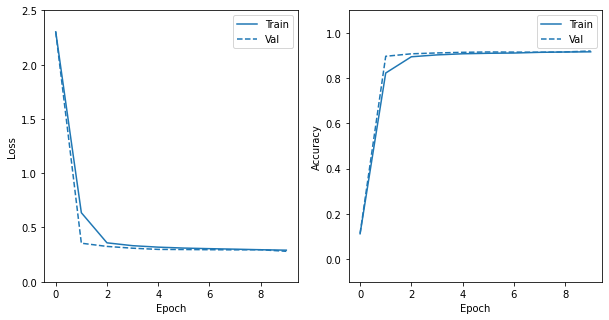

In [ ]:
plot_metrics(baseline_history) 

We evaluate the trained model.

In [ ]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.919


Use the model to make predictions. Therefore, we first the define a function to predict the digits of the first $10\times 10$ images printed in a square (followed by a square of the actual digits). 

In [ ]:
def print_res(model):
    i_range = 10
    ys = zeros(i_range * i_range)
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m'
    for i in range(10):
        for j in range(i_range):
            idx = i*i_range+j;
            image = x_test[idx]
            yhat = model.predict([[image]])
            ys[idx] = argmax(yhat)
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j;
            y = y_test[idx]
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '')            
        print()

In [ ]:
xx = x_test[9]
xxx = np.asarray([xx])
yhat = baseline.predict(xxx)
argmax(yhat)

NameError: ignored

In [ ]:
print_res(baseline)

There are 4% mistatakes in the first 100 images. The classic dense layer does quite good already.

## Adding Pooling

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=2x2`, i.e., no effective CNN and we even squeeze the image size.

In [ ]:
# def make_model(depth, kernel_width, pool_stride, add_dense = False):
model1 = make_model(1,1,2)
model1.summary()

The kernel has still one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the pooling layers is one quater (half in each dimension) of the CNN in- and output.

We train the first CNN model.

In [ ]:
model1_history = model1.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

... and show the history of training.

In [ ]:
plot_metrics(model1_history) 

We evaluate the trained model.

In [ ]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Use the model to  make predictions.

In [ ]:
print_res(model1)

No surprise that the accuracy drops and that there are more mistatakes (7%) in the first 100 images.

## Adding a CNN Kernel

We set `depth=1`, `kernel_width=3x3`, and `pool_stride=2x2`, i.e., one effective CNN layer followed by the pooling layer.

In [ ]:
# def make_model(depth, kernel_width, pool_stride, add_dense = False):
model2 = make_model(1,3,2)
model2.summary()

The kernel has still $3\times 3$ weights and one bias, i.e., `Param = 10` for the CNN layer. No padding is applied, so the CNN layer 'eats' one pixel at the corners, i.e., its output shape is `(26, 26, 1)`. The output of the pooling layers is one quater (half in $x$ and $y$ dimension) of the CNN output.

We train the first real CNN model.

In [ ]:
model2_history = model2.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

... and show the history of training.

In [ ]:
plot_metrics(model2_history) 

We evaluate the trained model.

In [ ]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Use the model to  make predictions.

In [ ]:
print_res(model2)

The accuracy and that the number of mistatakes in the first 100 images is on par with the baseline model.

## Adding Parallel CNN Kernels

We set `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2x2`.

In [ ]:
# def make_model(depth, kernel_width, pool_stride, add_dense = False):
model3 = make_model(32,3,2)
model3.summary()

There are $32$ kernels has each with $3 \times 3$ weights and one bias, i.e., `Param = 32` for the CNN layer. As no padding is applied, the CNN layer's output shape is the same for the $x$ and $y$ dimensions , but it add depth: `(26, 26, 32)`. The output of the pooling layers is one quater (half in $x$ and $y$ dimension) of the CNN output, but it keeps the depth.

We train the first CNN model.

In [ ]:
model3_history = model3.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

... and show the history of training.

In [ ]:
plot_metrics(model3_history) 

We evaluate the trained model.

In [ ]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Use the model to make predictions.

In [ ]:
print_res(model3)

The accuracy goes up to almost 100% and there are only 2% mistatakes in the first 100 images.

## Adding another dense output layer

We keep `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2x2` but add another dense layer before the output layer as suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model4.add(MaxPool2D((2, 2)))
model4.add(Flatten())
model4.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(Dense(n_classes, activation='softmax'))

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model4.summary()

This lets the number of parameters grow to over half a million!

We train this final CNN model.

In [ ]:
model4_history = model4.fit(
    x_train, 
    y_train, 
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),    
    batch_size=BATCH_SIZE)

Training time goes up to $12\ldots 15 \mathit{s}$ compared to $<10 \mathit{s}$ per epoch before. 

Here the history of training.

In [ ]:
plot_metrics(model4_history) 

We evaluate the trained model.

In [ ]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Use the model to  make predictions.

In [ ]:
print_res(model4)

The accuracy goes up a bit and there are only 1% mistatakes left in the first 100 images.